# Part 2 - Perpespective Transformation

### Load camera calibration and test it.

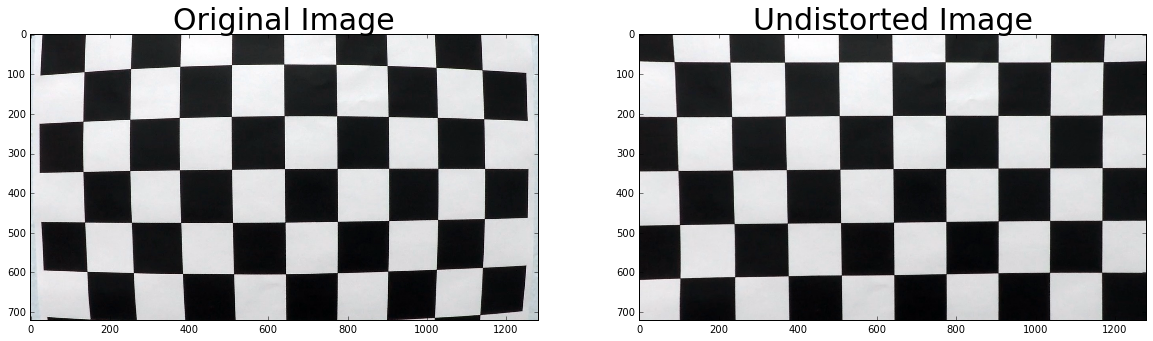

In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Read in the saved camera matrix and distortion coefficients
# These are the arrays we calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "camera_cal/camera_cal_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read and undistort image test
img = cv2.imread('camera_cal/test_image/test_image2.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_image/test_undist2.jpg',dst)

#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

### Undistort road images as a test.

In [2]:
import glob

# Make a list of images
images = glob.glob('test_images/test*.jpg')
images.sort()

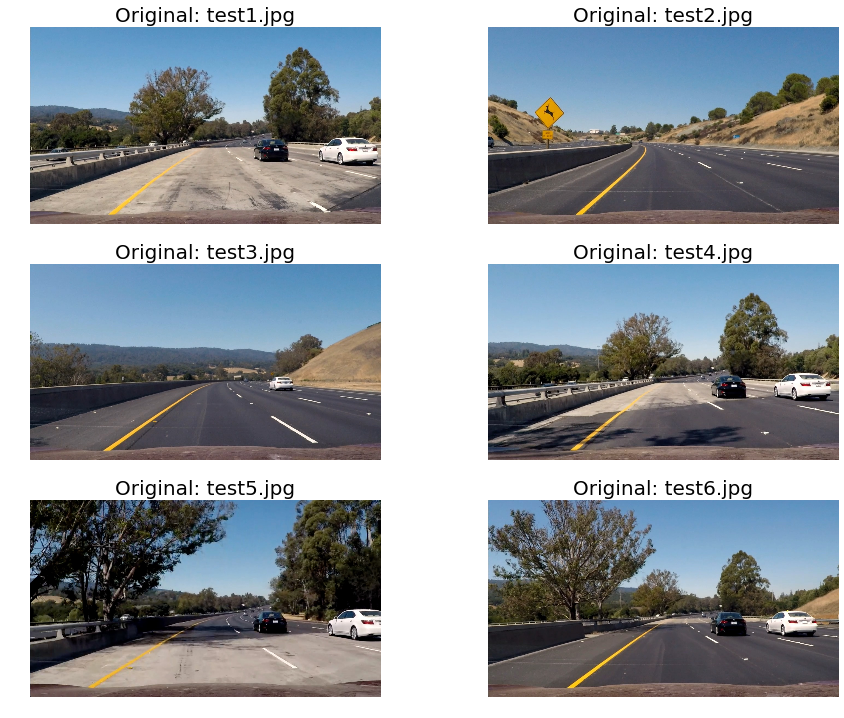

In [3]:
#  Plotting function for images
def plotImages(images, ncols=1, cmap=None, prefix_label = 'label:'):
    """
    Plot images in a subplot arrangement.
    images = python list of images full path
    ncols = numbers of columns in the image plot arrangement
    prefix_label = prefix label to show on top of images
    """
    from os.path import basename
    
    nrows = int(np.ceil(len(images) / ncols))
    scalesize = nrows*ncols
    f, axarr = plt.subplots(nrows, ncols, figsize=(8*ncols, 4*nrows))
    f.subplots_adjust(hspace=0.2, wspace=0.05)
    axarr = axarr.flatten() # iterate on plots via 1D
    
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axarr[idx].axis('off')
        axarr[idx].imshow(img, cmap=cmap)
        axarr[idx].set_title(prefix_label + ' ' + basename(images[idx]), fontsize=20)

plotImages(images, ncols=2, cmap=None, prefix_label = 'Original:')

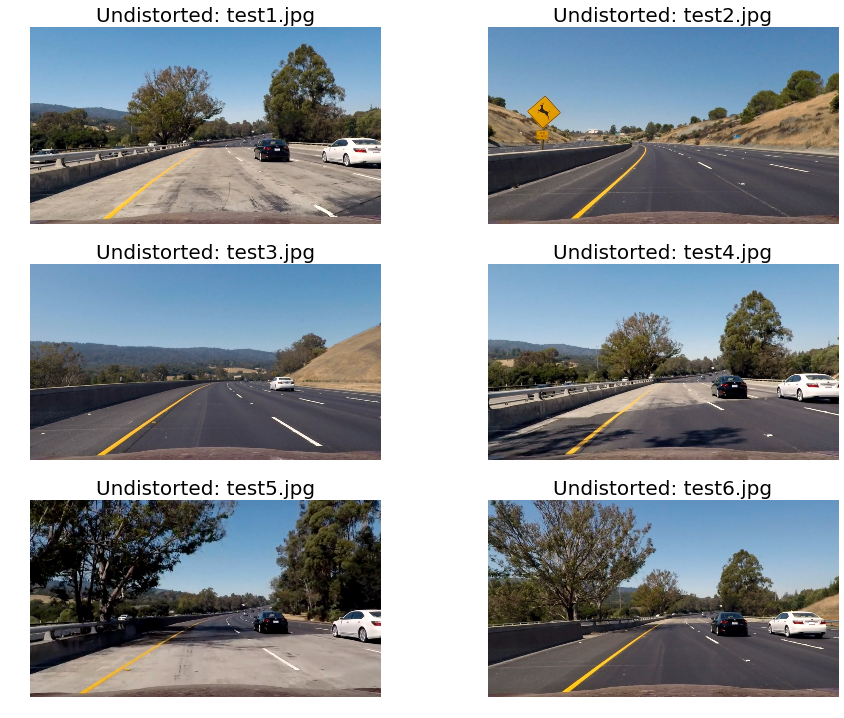

In [4]:
#  Plotting function for images
def plotImages_undistorted(images, mtx, dist, ncols=1, cmap=None, prefix_label = 'label:'):
    """
    Plot images in a subplot arrangement.
    images = python list of images full path
    ncols = numbers of columns in the image plot arrangement
    prefix_label = prefix label to show on top of images
    """
    from os.path import basename
    
    nrows = int(np.ceil(len(images) / ncols))
    scalesize = nrows*ncols
    f, axarr = plt.subplots(nrows, ncols, figsize=(8*ncols, 4*nrows))
    f.subplots_adjust(hspace=0.2, wspace=0.05)
    axarr = axarr.flatten() # iterate on plots via 1D
    
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        img = cv2.undistort(img, mtx, dist, None, mtx)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axarr[idx].axis('off')
        axarr[idx].imshow(img, cmap=cmap)
        axarr[idx].set_title(prefix_label + ' ' + basename(images[idx]), fontsize=20)

plotImages_undistorted(images, mtx, dist, ncols=2, cmap=None, prefix_label = 'Undistorted:')

### Here is a function to make sure that transformation source points are always sorted correctly

In [172]:
# Order points in clock-wise
# Inspired by this discussion:
# http://stackoverflow.com/questions/1709283/how-can-i-sort-a-coordinate-list-for-a-rectangle-counterclockwise
def order_points(pts):
    # normalises the input into the [0, 2pi] space, added 0.5*pi to initiate from top left
    # which naturally will sort it "counter-clockwise"
    mx = np.sum(pts.T[0]/len(pts))
    my = np.sum(pts.T[1]/len(pts))

    l = []
    for i in range(len(pts)):
        l.append(  (np.math.atan2(pts.T[0][i] - mx, pts.T[1][i] - my) + 2 * np.pi + 0.5 * np.pi) % (2*np.pi)  )
    sort_idx = np.argsort(l)
    
    return pts[sort_idx[::-1]]

### Here is a function to compute perspective transformation matrices.

In [173]:
def get_transform_matrices(pts, img_size):
    # obtain a consistent order of the points and unpack them
    # individually
    src = order_points(pts)
    #print(src)
    #print(src[3][0])
    #print(src[2][0])
    
    # destination points
    '''
    dst = np.float32([[0, 0],
                      [img_size[0]-1, 0], 
                      [img_size[0]-1, img_size[1]-1], 
                      [0, img_size[1]-1]])
    '''
    dst = np.float32([[src[3][0], 0],
                      [src[2][0], 0],
                      [src[2][0], img_size[1]],
                      [src[3][0], img_size[1]]])
    #'''
    
    print(dst)
    # compute the perspective transform matrix and the inverse of it
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    # return the matrices
    return M, Minv

### Test it on a road image.

(720, 1280, 3)
[[  100.     0.]
 [ 1200.     0.]
 [ 1200.   720.]
 [  100.   720.]]


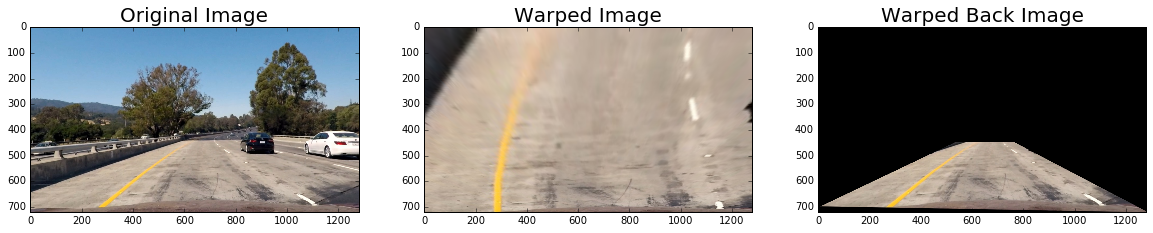

In [174]:
# load image
img = cv2.imread(images[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)

# undistort and get size
img = cv2.undistort(img, mtx, dist, None, mtx)
img_size = (img.shape[1], img.shape[0])

# get the points
pts = np.float32([[100,700],[550,450],[750,450],[1200,720]])
#print(pts)

# get the transform matrices
M, Minv = get_transform_matrices(pts, img_size)

# transform image
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

# transform it back
warped_back = cv2.warpPerspective(warped, Minv, img_size, flags=cv2.INTER_LINEAR)
    
# Visualize it
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=20)
ax3.imshow(warped_back)
ax3.set_title('Warped Back Image', fontsize=20)

### Here is function to optimize the choice of source points

In [175]:
# Re-using one of my functions
# Modified to crop car hood
def trapezoid_vertices(image, bottom_width=0.85,top_width=0.07,height=0.40, car_hood=45):
    """
    Create trapezoid vertices for mask. 
    Inpus:
    image
    bottom_width = percentage of image width
    top_width = percentage of image width
    height = percentage of image height
    """   
    imshape = image.shape
    
    vertices = np.array([[\
        ((imshape[1] * (1 - bottom_width)) // 2, imshape[0]-car_hood),\
        ((imshape[1] * (1 - top_width)) // 2, imshape[0] - imshape[0] * height + car_hood),\
        (imshape[1] - (imshape[1] * (1 - top_width)) // 2, imshape[0] - imshape[0] * height + car_hood),\
        (imshape[1] - (imshape[1] * (1 - bottom_width)) // 2, imshape[0] - car_hood)]]\
        , dtype=np.int32)
    
    return vertices


### Optimize source points by using a straight road image. Choose source points that warp lane lines to be vertical.

(720, 1280, 3)
[[ 384.    0.]
 [ 896.    0.]
 [ 896.  720.]
 [ 384.  720.]]


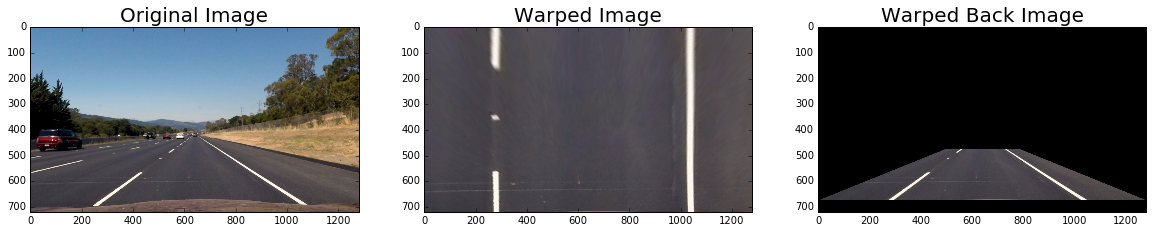

In [176]:
# Optimize source points and use straight road to find the for calibration
# load image
img = cv2.imread('test_images/straight_lines2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)

# undistort and get size
img = cv2.undistort(img, mtx, dist, None, mtx)
img_size = (img.shape[1], img.shape[0])

src = np.array([[262, 677], [580, 460], [703, 460], [1040, 677]]).astype(np.float32)
dst = np.array([[262, 720], [262, 0], [1040, 0], [1040, 720]]).astype(np.float32)

# get the points by image ratios
pts = trapezoid_vertices(img, bottom_width=0.4,top_width=0.092,height=0.4, car_hood=45)  # 1, 0.046, 0.4 --> 1, 0.167, 0,35
# 1, 0.115, 0.37,    0.59,0.11,0.43,55
pts = pts.reshape(pts.shape[1:])
pts = pts.astype(np.float32)
#print(pts)

# get the transform matrices
M, Minv = get_transform_matrices(pts, img_size)

# transform image
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

# transform it back
warped_back = cv2.warpPerspective(warped, Minv, img_size, flags=cv2.INTER_LINEAR)
    
# Visualize it
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=20)
ax3.imshow(warped_back)
ax3.set_title('Warped Back Image', fontsize=20)


### Save transformation matrices!

In [177]:
import pickle

# Save the transformation matrices for later use
dist_pickle = {}
dist_pickle["M"] = M
dist_pickle["Minv"] = Minv
pickle.dump( dist_pickle, open( "camera_cal/perspective_trans_matrices.p", "wb" ) )